# Introduction

In [1]:
using PyCall

py"""
def pymysum(a):
    result = 0
    for x in a:
        result += x
    return result
"""

pymysum = py"pymysum"

PyObject <function pymysum at 0x1291d5840>

In [5]:
N = 10_000_000
a = float.(collect(1:N))

pymysum(a)
@time pymysum(a)

  1.504624 seconds (28 allocations: 1.016 KiB)


5.0000005e13

In [6]:
@pyimport numpy as np

In [7]:
np.sum(a)
@time np.sum(a)

  0.004743 seconds (28 allocations: 1.016 KiB)


5.0000005e13

python's `main()` can be found here: https://github.com/python/cpython/blob/master/Programs/python.c

```C
/* Minimal main program -- everything is loaded from the library */

#include "Python.h"

#ifdef MS_WINDOWS
int
wmain(int argc, wchar_t **argv)
{
    return Py_Main(argc, argv);
}
#else
int
main(int argc, char **argv)
{
    return _Py_UnixMain(argc, argv);
}
#endif
```

In [10]:
# first call compiles the function
sum(a)

5.0000005e13

In [11]:
@time sum(a)

  0.006619 seconds (5 allocations: 176 bytes)


5.0000005e13

In [12]:
function mysum(a)
    result = zero(eltype(a))
    for x in a
        result += x
    end
    result
end

mysum (generic function with 1 method)

In [34]:
mysum(a)
@time mysum(a)

  0.010192 seconds (5 allocations: 176 bytes)


5.0000005e13

In [19]:
@less sum(a)

# This file is a part of Julia. License is MIT: https://julialang.org/license

## reductions ##

###### Generic (map)reduce functions ######

if Int === Int32
const SmallSigned = Union{Int8,Int16}
const SmallUnsigned = Union{UInt8,UInt16}
else
const SmallSigned = Union{Int8,Int16,Int32}
const SmallUnsigned = Union{UInt8,UInt16,UInt32}
end

const CommonReduceResult = Union{UInt64,UInt128,Int64,Int128,Float32,Float64}
const WidenReduceResult = Union{SmallSigned, SmallUnsigned, Float16}

# r_promote_type: promote T to the type of reduce(op, ::Array{T})
# (some "extra" methods are required here to avoid ambiguity warnings)
r_promote_type(op, ::Type{T}) where {T} = T
r_promote_type(op, ::Type{T}) where {T<:WidenReduceResult} = widen(T)
r_promote_type(::typeof(+), ::Type{T}) where {T<:WidenReduceResult} = widen(T)
r_promote_type(::typeof(*), ::Type{T}) where {T<:WidenReduceResult} = widen(T)
r_promote_type(::typeof(+), ::Type{T}) where {T<:Number} = typeof(zero(T)+zero(T))
r_promote_type(::t

Returns the sum of all elements in a collection.

```jldoctest
julia> sum(1:20)
210
```
"""
sum(a) = mapreduce(identity, +, a)
sum(a::AbstractArray{Bool}) = countnz(a)


# Kahan (compensated) summation: O(1) error growth, at the expense
# of a considerable increase in computational expense.

"""
    sum_kbn(A)

Returns the sum of all elements of `A`, using the Kahan-Babuska-Neumaier compensated
summation algorithm for additional accuracy.
"""
function sum_kbn(A)
    T = _default_eltype(typeof(A))
    c = r_promote(+, zero(T)::T)
    i = start(A)
    if done(A, i)
        return c
    end
    Ai, i = next(A, i)
    s = Ai - c
    while !(done(A, i))
        Ai, i = next(A, i)
        t = s + Ai
        if abs(s) >= abs(Ai)
            c -= ((s-t) + Ai)
        else
            c -= ((Ai-t) + s)
        end
        s = t
    end
    s - c
end

## prod
"""
    prod(f, itr)

Returns the product of `f` applied to each element of `itr`.

```jldoctest
julia> prod(abs2, [2; 3; 4])
576
```
"""


In [38]:
typeof(max)

Base.#max

In Julia `sum()` is defined as:
```julia
sum(a) = mapreduce(identity, +, a)
sum(a::AbstractArray{Bool}) = countnz(a)
```

Doing `julia> @less mapreduce(identity, +, a)` points to the same file, where we find:

```julia
## reduce & mapreduce

# `mapreduce_impl()` is called by `mapreduce()` (via `_mapreduce()`, when `A`
# supports linear indexing) and does actual calculations (for `A[ifirst:ilast]` subset).
```

The actual code:

```julia
function mapreduce_impl(f, op, A::AbstractArray, ifirst::Integer, ilast::Integer, blksize::Int=pairwise_blocksize(f, op))
    if ifirst == ilast
        @inbounds a1 = A[ifirst]
        return r_promote(op, f(a1))
    elseif ifirst + blksize > ilast
        # sequential portion
        @inbounds a1 = A[ifirst]
        @inbounds a2 = A[ifirst+1]
        v = op(r_promote(op, f(a1)), r_promote(op, f(a2)))
        @simd for i = ifirst + 2 : ilast
            @inbounds ai = A[i]
            v = op(v, f(ai))
        end
        return v
    else
        # pairwise portion
        imid = (ifirst + ilast) >> 1
        v1 = mapreduce_impl(f, op, A, ifirst, imid, blksize)
        v2 = mapreduce_impl(f, op, A, imid+1, ilast, blksize)
        return op(v1, v2)
    end
end
```

## Quicksort - less trivial example

In [23]:
# stolen from https://stackoverflow.com/a/18262384
py"""
def pymyquicksort(array):
    less = []
    equal = []
    greater = []

    if len(array) > 1:
        pivot = array[0]
        for x in array:
            if x < pivot:
                less.append(x)
            if x == pivot:
                equal.append(x)
            if x > pivot:
                greater.append(x)
        # Don't forget to return something!
        return pymyquicksort(less) + equal + pymyquicksort(greater)  # Just use the + operator to join lists
    # Note that you want equal ^^^^^ not pivot
    else:  # You need to hande the part at the end of the recursion - when you only have one element in your array, just return the array.
        return array
"""
pymyquicksort = py"pymyquicksort"

PyObject <function pymyquicksort at 0x13022ce18>

In [24]:
A = rand(100_000)
@time pymyquicksort(A)

  0.947976 seconds (211.75 k allocations: 5.191 MiB)


100000-element Array{Float64,1}:
 1.48128e-5 
 1.54889e-5 
 2.34351e-5 
 3.1999e-5  
 3.53653e-5 
 8.76275e-5 
 9.26869e-5 
 0.000107586
 0.000117944
 0.00012328 
 0.000133145
 0.000137021
 0.000143654
 ⋮          
 0.999892   
 0.999932   
 0.999946   
 0.999949   
 0.999953   
 0.99996    
 0.999969   
 0.999971   
 0.999976   
 0.999993   
 0.999997   
 0.999998   

In [25]:
function myquicksort(A)
    length(A) > 1 || return A
    
    less = similar(A, 0)
    equal = similar(A, 0)
    greater = similar(A, 0)

    pivot = A[1]
    for x in A
        x < pivot && push!(less, x)
        x == pivot && push!(equal, x)
        x > pivot && push!(greater, x)
    end
    
    [ myquicksort(less); equal; myquicksort(greater) ]
end

myquicksort (generic function with 1 method)

In [30]:
myquicksort(A)
@time myquicksort(A)

  0.078021 seconds (509.63 k allocations: 88.179 MiB, 25.27% gc time)


100000-element Array{Float64,1}:
 1.48128e-5 
 1.54889e-5 
 2.34351e-5 
 3.1999e-5  
 3.53653e-5 
 8.76275e-5 
 9.26869e-5 
 0.000107586
 0.000117944
 0.00012328 
 0.000133145
 0.000137021
 0.000143654
 ⋮          
 0.999892   
 0.999932   
 0.999946   
 0.999949   
 0.999953   
 0.99996    
 0.999969   
 0.999971   
 0.999976   
 0.999993   
 0.999997   
 0.999998   

In [32]:
@code_native myquicksort(A)

	.section	__TEXT,__text,regular,pure_instructions
Filename: In[25]
	pushq	%rbp
	movq	%rsp, %rbp
	pushq	%r15
	pushq	%r14
	pushq	%r13
	pushq	%r12
	pushq	%rbx
	subq	$200, %rsp
	movq	%rdi, %r12
	movabsq	$jl_get_ptls_states_fast, %rax
	callq	*%rax
	movq	%rax, %r15
	movq	$0, -80(%rbp)
	movq	$0, -88(%rbp)
	movq	$0, -96(%rbp)
	movq	$0, -104(%rbp)
	movq	$0, -120(%rbp)
	movq	$0, -128(%rbp)
	movq	$0, -136(%rbp)
	movq	$0, -144(%rbp)
	movq	$0, -152(%rbp)
	movq	$0, -160(%rbp)
	movq	$0, -168(%rbp)
	movq	$0, -176(%rbp)
	movq	$0, -184(%rbp)
	movq	$0, -192(%rbp)
	movq	$0, -200(%rbp)
	movq	$0, -208(%rbp)
	movq	$0, -216(%rbp)
	movq	$36, -232(%rbp)
	movq	(%r15), %rax
	movq	%rax, -224(%rbp)
	leaq	-232(%rbp), %rax
	movq	%rax, (%r15)
	movq	$0, -112(%rbp)
Source line: 2
	cmpq	$1, 8(%r12)
	jg	L282
	movq	-224(%rbp), %rax
	movq	%rax, (%r15)
	movq	%r12, %rax
	leaq	-40(%rbp), %rsp
	popq	%rbx
	popq	%r12
	popq	%r13
	popq	%r14
	popq	%r15
	popq	%rbp
	retq
L282:
	movabsq	$jl_alloc_array_1d, %r13
Source line: 4
	leaq	929

In [27]:
square_area(a) = a * a

square_area (generic function with 1 method)

In [94]:
code_native(square_area, (Int32,))

	.section	__TEXT,__text,regular,pure_instructions
Filename: In[93]
	pushq	%rbp
	movq	%rsp, %rbp
Source line: 1
	imull	%edi, %edi
	movl	%edi, %eax
	popq	%rbp
	retq
	nopl	(%rax,%rax)


In [33]:
code_native(square_area, (Float64,))

	.section	__TEXT,__text,regular,pure_instructions
Filename: In[27]
	pushq	%rbp
	movq	%rsp, %rbp
Source line: 1
	mulsd	%xmm0, %xmm0
	popq	%rbp
	retq
	nopw	(%rax,%rax)


# Fresnel propagation

`PyPlot` is already installed, but installing it is as simple as:

`julia> Pkg.add("PyPlot")`

Julia has a built-in package manager.

In [1]:
using PyPlot

In [40]:
"The rectangle function."
rect(x) = one(x) * (abs(x) < 0.5)

"A circular grating"
circle(x, y, m, L) = m * rect(sqrt(x^2 + y^2) / 2L)

circle

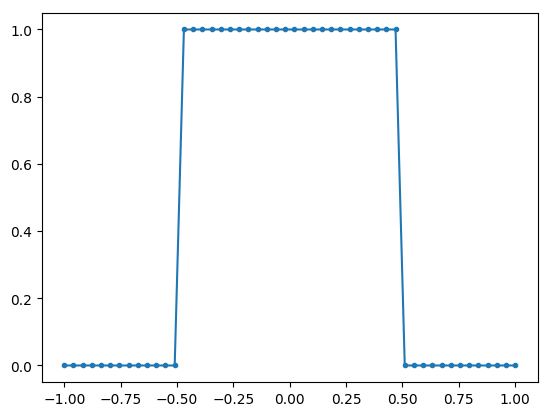

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x141115d30>

In [41]:
x = linspace(-1, 1)
plot(x, rect.(x), ".-")

In [42]:
"frequencies for which the fft is calculated"
fftfreq(n) = ifftshift(-cld(n-1, 2) : fld(n-1, 2)) / n

"Transfer function for the Fresnel free propagation."
H(fx, fy, λ, z) = exp(-im * π * λ * z * (fx^2 + fy^2))

H

In [55]:
δx = δy = 0.1e-6
# Make sure Nx is a power of 2 for performance reasons
Nx = Ny = nextprod([2], 4000)

# x is a row vector, y is a column vector
x = δx * (collect(1:Nx) - Nx/2)'
y = δy * (collect(1:Ny) - Ny/2)

fx = (fftfreq(length(x)) ./ δx)'
fy = fftfreq(length(y)) ./ δy

4096-element Array{Float64,1}:
      0.0 
   2441.41
   4882.81
   7324.22
   9765.63
  12207.0 
  14648.4 
  17089.8 
  19531.3 
  21972.7 
  24414.1 
  26855.5 
  29296.9 
      ⋮   
 -29296.9 
 -26855.5 
 -24414.1 
 -21972.7 
 -19531.3 
 -17089.8 
 -14648.4 
 -12207.0 
  -9765.63
  -7324.22
  -4882.81
  -2441.41

In [56]:
u0 = ones(Complex128, length(y), length(x))

# grating 20μm
p1 = 20e-6
u1 = u0 .* circle.(x, y, 1, p1)
U1 = fft(u1)

# wavelength 100pm
λ = 100e-12
u2(z) = ifft(U1 .* H.(fx, fy, λ, z), (1, 2))

"The distance for the given Fresnel number"
NF2z(NF) = (p1/2)^2 / (λ * NF)

NF2z

In [58]:
z = NF2z(2)
intensity_image = abs.(u2(z)).^2

4096×4096 Array{Float64,2}:
 8.53723e-5   2.22064e-5  6.73061e-6  3.17539e-5  …  8.53723e-5   0.000122974
 2.22064e-5   8.73651e-6  1.52025e-6  3.51344e-6     2.22064e-5   2.91737e-5 
 6.73061e-6   1.52025e-6  2.61547e-6  4.96522e-6     6.73061e-6   1.06978e-5 
 3.17539e-5   3.51344e-6  4.96522e-6  2.13609e-5     3.17539e-5   5.10666e-5 
 3.99198e-5   7.54487e-6  2.22216e-6  1.7782e-5      3.99198e-5   5.98337e-5 
 2.35365e-5   8.6161e-6   2.54916e-7  2.70762e-6  …  2.35365e-5   3.11157e-5 
 2.38469e-5   9.56857e-6  5.79152e-6  6.83606e-6     2.38469e-5   3.29052e-5 
 4.60656e-5   1.35762e-5  1.18957e-5  2.17695e-5     4.60656e-5   6.82271e-5 
 4.98812e-5   1.73212e-5  9.65732e-6  1.65396e-5     4.98812e-5   7.01388e-5 
 2.82905e-5   1.55557e-5  5.20021e-6  1.10031e-6     2.82905e-5   3.42405e-5 
 2.35646e-5   9.03755e-6  8.81894e-6  1.23885e-5  …  2.35646e-5   3.37567e-5 
 4.85089e-5   4.17927e-6  1.50466e-5  4.17085e-5     4.85089e-5   8.20864e-5 
 6.41935e-5   6.85562e-6  1.16104e-5

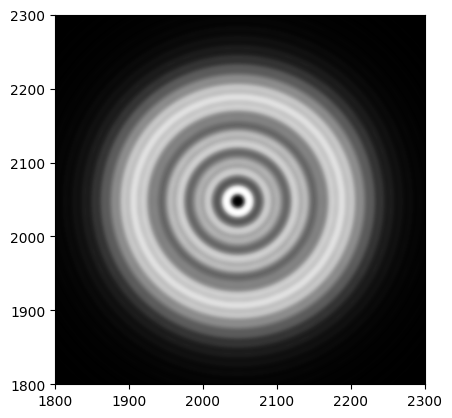

(1800, 2300)

In [59]:
imshow(intensity_image,
    cmap = "Greys_r",
    interpolation = "bicubic",
    aspect = 1)
xlim(1800, 2300)
ylim(1800, 2300)

# Intergrating with Python

In [1]:
using PyCall

In [2]:
@pyimport scipy.optimize as so
so.newton(x -> cos(x) - x, 1)

0.7390851332151607

Single line `py"..."` returns a value, but has to be a single expression.

In [16]:
py"len([12, 23])"

2

Multiline `py"""..."""` can execute arbitrary python code, but returns `nothing`.

In [4]:
py"""
def python_add(a, b):
    return a + b
"""
python_add = py"python_add"

PyObject <function python_add at 0x1258dce18>

In [5]:
python_add(2, 2)

4

# Plotting with matplotlib

In [6]:
using PyPlot

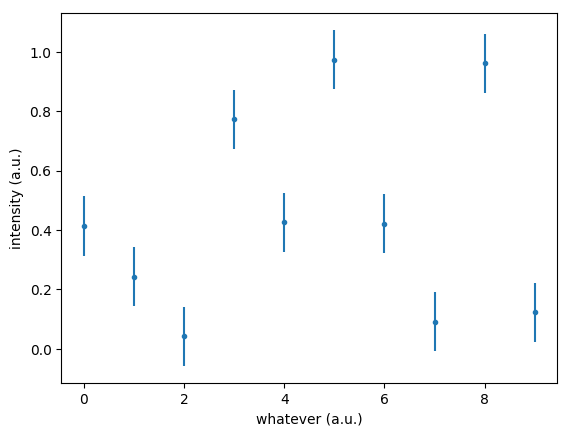

PyObject Text(24,0.5,'intensity (a.u.)')

In [7]:
errorbar(0:9, rand(10), fmt = ".", yerr = 0.1)
xlabel("whatever (a.u.)")
ylabel("intensity (a.u.)")

# Calling C

In [8]:
ccall((:clock, "libc"), Int32, ())

23020496

In [9]:
ccall((:getenv, "libc"), Cstring, (Cstring,), "SHELL") |> unsafe_string

"/usr/local/bin/fish"

Can easily wrap functions:

In [156]:
getenv(v) = ccall((:getenv, "libc"), Cstring, (Cstring,), v) |> unsafe_string

getenv (generic function with 1 method)

In [157]:
getenv("HOME")

"/Users/rawlik"

# C++ integration

In [11]:
using Cxx

In [12]:
cxx""" #include<iostream> """

true

In [13]:
cxx"""  
  void mycppfunction() {   
    int z = 0;
    int y = 4;
    int x = 10;
    z = x*y + 2;
    std::cout << "The number is " << z << std::endl;
 }
"""

true

In [14]:
julia_function() = @cxx mycppfunction()

julia_function (generic function with 1 method)

In [15]:
julia_function()

The number is 42


# Parallel computing

In [108]:
incircle(x, y, r) = x^2 + y^2 < r^2

incircle (generic function with 2 methods)

In [139]:
function estimateπ(N)
    inside = 0
    for i in 1:N
        x = rand() - 0.5
        y = rand() - 0.5

        incircle(x, y, 0.5) && (inside += 1)
    end
    inside / N / 0.5^2
end
    

estimateπ(1000)
@time estimateπ(100_000_000)

  0.766159 seconds (5 allocations: 176 bytes)


3.1415866

In [118]:
addprocs(4)

4-element Array{Int64,1}:
 2
 3
 4
 5

In [120]:
@everywhere @show myid()

myid() = 1
	From worker 2:	myid() = 2
	From worker 3:	myid() = 3
	From worker 5:	myid() = 5
	From worker 4:	myid() = 4


In [121]:
@everywhere incircle(x, y, r) = x^2 + y^2 < r^2

In [143]:
N = 100_000_000
Nworker = N ÷ nworkers()

@time inside = @parallel (+) for i in 1:N
    x = rand() - 0.5
    y = rand() - 0.5

    incircle(x, y, 0.5)
end

inside / N / 0.5^2

  0.974254 seconds (3.61 k allocations: 221.415 KiB)


3.14171524

# Shell-capabilities

In [21]:
run(`ls`)

README.md
REQUIRE
apt.txt
environment.yml
seminar.ipynb


In [35]:
notmygroup = "kirch"

"kirch"

In [36]:
run(`ssh mrawlik@login.phys.ethz.ch ls /home/$notmygroup/users`)

AldoAntognini
AndreasEggenberger
EnricoDelRe
FlorianPiegsa
GuntherWichmann
HannoBertle
IvanaBelosevic
IvoSchulthess
JochenKrempel
KarstenSchuhmann
ManuelZeyen
MartinPototschnig
MichalRawlik
MiroslawMarszalek
RyotoIwai
SimonScheidegger
SolangeEmmenegger
StellaVogiatzi


In [53]:
[ matchall(r"[A-Z][a-z]+", s)[2:end]
    for s in 
    readstring(`ssh mrawlik@login.phys.ethz.ch ls /home/$notmygroup/users`) |> split ]

18-element Array{Array{SubString{String},1},1}:
 SubString{String}["Antognini"]  
 SubString{String}["Eggenberger"]
 SubString{String}["Del", "Re"]  
 SubString{String}["Piegsa"]     
 SubString{String}["Wichmann"]   
 SubString{String}["Bertle"]     
 SubString{String}["Belosevic"]  
 SubString{String}["Schulthess"] 
 SubString{String}["Krempel"]    
 SubString{String}["Schuhmann"]  
 SubString{String}["Zeyen"]      
 SubString{String}["Pototschnig"]
 SubString{String}["Rawlik"]     
 SubString{String}["Marszalek"]  
 SubString{String}["Iwai"]       
 SubString{String}["Scheidegger"]
 SubString{String}["Emmenegger"] 
 SubString{String}["Vogiatzi"]   

In [55]:
run(pipeline(`ssh mrawlik@login.phys.ethz.ch ls /home/$notmygroup/users`, `wc -l`))

      18


# Type system and multiple-dispatch

In [19]:
methods(+)

# 187 methods for generic function "+":
+(x::Bool, z::Complex{Bool}) in Base at complex.jl:232
+(x::Bool, y::Bool) in Base at bool.jl:89
+(x::Bool) in Base at bool.jl:86
+(x::Bool, y::T) where T<:AbstractFloat in Base at bool.jl:96
+(x::Bool, z::Complex) in Base at complex.jl:239
+(a::Float16, b::Float16) in Base at float.jl:372
+(x::Float32, y::Float32) in Base at float.jl:374
+(x::Float64, y::Float64) in Base at float.jl:375
+(z::Complex{Bool}, x::Bool) in Base at complex.jl:233
+(z::Complex{Bool}, x::Real) in Base at complex.jl:247
+(x::Char, y::Integer) in Base at char.jl:40
+(c::BigInt, x::BigFloat) in Base.MPFR at mpfr.jl:312
+(a::BigInt, b::BigInt, c::BigInt, d::BigInt, e::BigInt) in Base.GMP at gmp.jl:334
+(a::BigInt, b::BigInt, c::BigInt, d::BigInt) in Base.GMP at gmp.jl:327
+(a::BigInt, b::BigInt, c::BigInt) in Base.GMP at gmp.jl:321
+(x::BigInt, y::BigInt) in Base.GMP at gmp.jl:289
+(x::BigInt, c::Union{UInt16, UInt32, UInt64, UInt8}) in Base.GMP at gmp.jl:346
+(x::BigInt, c::Union{Int16, Int32, Int64, Int8}) in Base.GMP at gmp.jl:362
+(a::BigFloat, b::BigFloat, c::BigFloat, d::BigFloat, e::BigFloat) in Base.MPFR at mpfr.jl:460
+(a::BigFloat, b::BigFloat, c::BigFloat, d::BigFloat) in Base.MPFR at mpfr.jl:453
+(a::BigFloat, b::BigFloat, c::BigFloat) in Base.MPFR at mpfr.jl:447
+(x::BigFloat, c::BigInt) in Base.MPFR at mpfr.jl:308
+(x::BigFloat, y::BigFloat) in Base.MPFR at mpfr.jl:277
+(x::BigFloat, c::Union{UInt16, UInt32, UInt64, UInt8}) in Base.MPFR at mpfr.jl:284
+(x::BigFloat, c::Union{Int16, Int32, Int64, Int8}) in Base.MPFR at mpfr.jl:292
+(x::BigFloat, c::Union{Float16, Float32, Float64}) in Base.MPFR at mpfr.jl:300
+(B::BitArray{2}, J::UniformScaling) in Base.LinAlg at linalg/uniformscaling.jl:59
+(a::Base.Pkg.Resolve.VersionWeights.VWPreBuildItem, b::Base.Pkg.Resolve.VersionWeights.VWPreBuildItem) in Base.Pkg.Resolve.VersionWeights at pkg/resolve/versionweight.jl:87
+(a::Base.Pkg.Resolve.VersionWeights.VWPreBuild, b::Base.Pkg.Resolve.VersionWeights.VWPreBuild) in Base.Pkg.Resolve.VersionWeights at pkg/resolve/versionweight.jl:135
+(a::Base.Pkg.Resolve.VersionWeights.VersionWeight, b::Base.Pkg.Resolve.VersionWeights.VersionWeight) in Base.Pkg.Resolve.VersionWeights at pkg/resolve/versionweight.jl:197
+(a::Base.Pkg.Resolve.MaxSum.FieldValues.FieldValue, b::Base.Pkg.Resolve.MaxSum.FieldValues.FieldValue) in Base.Pkg.Resolve.MaxSum.FieldValues at pkg/resolve/fieldvalue.jl:44
+(x::Base.Dates.CompoundPeriod, y::Base.Dates.CompoundPeriod) in Base.Dates at dates/periods.jl:349
+(x::Base.Dates.CompoundPeriod, y::Base.Dates.Period) in Base.Dates at dates/periods.jl:347
+(x::Base.Dates.CompoundPeriod, y::Base.Dates.TimeType) in Base.Dates at dates/periods.jl:387
+(x::Date, y::Base.Dates.Day) in Base.Dates at dates/arithmetic.jl:77
+(x::Date, y::Base.Dates.Week) in Base.Dates at dates/arithmetic.jl:75
+(dt::Date, z::Base.Dates.Month) in Base.Dates at dates/arithmetic.jl:58
+(dt::Date, y::Base.Dates.Year) in Base.Dates at dates/arithmetic.jl:32
+(dt::Date, t::Base.Dates.Time) in Base.Dates at dates/arithmetic.jl:20
+(t::Base.Dates.Time, dt::Date) in Base.Dates at dates/arithmetic.jl:24
+(x::Base.Dates.Time, y::Base.Dates.TimePeriod) in Base.Dates at dates/arithmetic.jl:81
+(dt::DateTime, z::Base.Dates.Month) in Base.Dates at dates/arithmetic.jl:52
+(dt::DateTime, y::Base.Dates.Year) in Base.Dates at dates/arithmetic.jl:28
+(x::DateTime, y::Base.Dates.Period) in Base.Dates at dates/arithmetic.jl:79
+(a::PyCall.PyObject, b::PyCall.PyObject) in PyCall at /Users/rawlik/.julia/v0.6/PyCall/src/pyoperators.jl:12
+(a::PyCall.PyObject) in PyCall at /Users/rawlik/.julia/v0.6/PyCall/src/pyoperators.jl:42
+(a::PyCall.PyObject, b) in PyCall at /Users/rawlik/.julia/v0.6/PyCall/src/pyoperators.jl:14
+(y::AbstractFloat, x::Bool) in Base at bool.jl:98
+(x::T, y::T) where T<:Union{Int128, Int16, Int32, Int64, Int8, UInt128, UInt16, UInt32, UInt64, UInt8} in Base at int.jl:32
+(x::Integer, y::Ptr) in Base at pointer.jl:128
+(z::Complex, w

# The down side of julia

In [61]:
@time `julia -e "println(2+2)"` |> run

4
  1.692079 seconds (735 allocations: 39.375 KiB)


In [63]:
@time `python3 -c "print(2+2)"` |> run

4
  0.269003 seconds (712 allocations: 39.391 KiB)


# Crash-course

In [60]:
2

2

In [61]:
2 + 1im

2 + 1im

In [62]:
1im^2

-1 + 0im

In [63]:
2//3

2//3

In [69]:
pi

π = 3.1415926535897...

In [70]:
2π

6.283185307179586

In [71]:
2(3+2)

10

In [72]:
5 / 2

2.5

In [73]:
5 ÷ 2

2

In [74]:
1 / 0

Inf

In [75]:
2 << 1

4

Constants have constant *type*.

In [31]:
const constant = 3

3

In [32]:
constant = 4

4

In [33]:
constant = 3.14

LoadError: [91minvalid redefinition of constant constant[39m

## Arrays

In [34]:
a = [4, 5, 6]

3-element Array{Int64,1}:
 4
 5
 6

In [35]:
a[1]

4

In [36]:
a = [4; 5; 6]

3-element Array{Int64,1}:
 4
 5
 6

In [37]:
a[end]

6

In [38]:
a[end - 1]

5

In [39]:
a[]

4

In [40]:
a[[1, 3]]

2-element Array{Int64,1}:
 4
 6

In [41]:
a[[true, false, true]]

2-element Array{Int64,1}:
 4
 6

In [42]:
1:5

1:5

In [43]:
collect(1:5)

5-element Array{Int64,1}:
 1
 2
 3
 4
 5

In [44]:
a[1:3]

3-element Array{Int64,1}:
 4
 5
 6

In [45]:
a[2:end]

2-element Array{Int64,1}:
 5
 6

In [46]:
a[end:-1:1]

3-element Array{Int64,1}:
 6
 5
 4

In [47]:
a[1] = 0

0

In [48]:
a

3-element Array{Int64,1}:
 0
 5
 6

In [49]:
matrix = [1 2; 3 4]

2×2 Array{Int64,2}:
 1  2
 3  4

In [50]:
matrix = [1 2
          3 4]

2×2 Array{Int64,2}:
 1  2
 3  4

In [51]:
b = Int8[4, 5, 6]

3-element Array{Int8,1}:
 4
 5
 6

In [52]:
10a

3-element Array{Int64,1}:
  0
 50
 60

In [53]:
matrix * [10, 20]

2-element Array{Int64,1}:
  50
 110

Julia distinguishes row and column vectors:

In [54]:
x = [1, 2]

2-element Array{Int64,1}:
 1
 2

In [55]:
y = [1 2]

1×2 Array{Int64,2}:
 1  2

In [56]:
x * y

2×2 Array{Int64,2}:
 1  2
 2  4

In [57]:
y * x

1-element Array{Int64,1}:
 5

In [58]:
matrix'

2×2 Array{Int64,2}:
 1  3
 2  4

In [59]:
[1, 2] * [3, 4]

LoadError: [91mDimensionMismatch("Cannot multiply two vectors")[39m

Use the so-called dot operators to perform operations element-wise

In [60]:
[1, 2] .* [3, 4]

2-element Array{Int64,1}:
 3
 8

Dot operators support broadcasting - singleton dimensions are automatically expanded

In [61]:
[1 2; 3 4] .* [10, 20]

2×2 Array{Int64,2}:
 10  20
 60  80

In [62]:
[1 2; 3 4] .* [10 10; 20 20]

2×2 Array{Int64,2}:
 10  20
 60  80

In [63]:
a

3-element Array{Int64,1}:
 0
 5
 6

In [64]:
a .= 7

3-element Array{Int64,1}:
 7
 7
 7

In [65]:
b = [1, 2, 3]
c = [10, 20, 30]

3-element Array{Int64,1}:
 10
 20
 30

In [66]:
a .= b .* c

3-element Array{Int64,1}:
 10
 40
 90

In [67]:
@. a = b * c

3-element Array{Int64,1}:
 10
 40
 90

In [68]:
a[a.>20]

2-element Array{Int64,1}:
 40
 90

## Strings

In [69]:
s = "This is a string."

"This is a string."

In [70]:
"""You can
have multiline strings, too."""

"You can\nhave multiline strings, too."

In [71]:
'a'

'a': ASCII/Unicode U+0061 (category Ll: Letter, lowercase)

In [72]:
s[1]

'T': ASCII/Unicode U+0054 (category Lu: Letter, uppercase)

In [73]:
s[1:4]

"This"

In [74]:
utf8string = "Θεσσαλονίκη"

"Θεσσαλονίκη"

In [75]:
utf8string[1]

'Θ': Unicode U+0398 (category Lu: Letter, uppercase)

In [76]:
utf8string[2]

LoadError: [91mUnicodeError: invalid character index 2 (0x98 is a continuation byte)[39m

In [77]:
[ c for c in utf8string ]

11-element Array{Char,1}:
 'Θ'
 'ε'
 'σ'
 'σ'
 'α'
 'λ'
 'ο'
 'ν'
 'ί'
 'κ'
 'η'

In [78]:
s[1] = "T"

LoadError: [91mMethodError: no method matching setindex!(::String, ::String, ::Int64)[39m

`$` is used for interpolation.

In [79]:
"pi is $pi"

"pi is π = 3.1415926535897..."

In [80]:
"2 + 2 = $(2 + 2)"

"2 + 2 = 4"

In [81]:
@printf "%d is less than %f" 4.5 5.3

5 is less than 5.300000

In [82]:
@sprintf "%d is less than %f" 4.5 5.3

"5 is less than 5.300000"

In [83]:
print("Print without newline... ")
println("Print with newline at the end.")

Print without newline... Print with newline at the end.


In [84]:
"one" * "two"

"onetwo"

In [85]:
"one"^3

"oneoneone"

In [86]:
ismatch(r"^\s*(?:#|$)", "not a comment")

false

In [87]:
ismatch(r"^\s*(?:#|$)", "# a comment")

true

In [88]:
b"abc"

3-element Array{UInt8,1}:
 0x61
 0x62
 0x63

In [ ]:

##############
# Collections
##############

a = [] # => Any[]
# Any is the supertype of all types  (more on that later).
# This means, that this vector can hold anything.

# Add stuff to the end of a with push! (single element)
# and append! (another collection)
push!(a, 1)     # => Any[1]
push!(a, 2)     # => Any[1,2]
push!(a, 4)     # => Any[1,2,4]
push!(a, 3)     # => Any[1,2,4,3]
append!(a, ["six", π]) # => Any[1,2,4,3,"six",π = 3.14…]
# By convention, function names that end in exclamations points indicate that
# they modify their arguments. Usually it is the first argument being modified.

# Remove from the end with pop
pop!(a) # => π = 3.14…
a # => [1,2,4,3,"six"]

# we also have shift and unshift
shift!(a) # => 1
a # => [2,4,3,"six"]
unshift!(a, 7) # => [7,2,4,3,"six"]

# Remove elements from an array by index with splice!
splice!(a, 2) # => 2
a # => [7,4,3,"six"]

# Check for existence in a list with in
in(1, a) # => false
3 in a # => true

# Examine the length with length
length(a) # => 4

# Sorting
arr = [5,4,6] # => 3-element Int64 Array: [5,4,6]
sort(arr) # => [4,5,6]
arr # => [5,4,6]
sort!(arr) # => [4,5,6]
arr # => [4,5,6]


# Tuples are immutable.
tup = (1, 2, 3) # => (1,2,3) # an (Int64,Int64,Int64) tuple.
tup[1] # => 1
try:
    tup[1] = 3 # => ERROR: MethodError: no method matching
               #    setindex!(::Tuple{Int64,Int64,Int64}, ::Int64, ::Int64)
catch e
    println(e)
end

# Many list functions also work on tuples
length(tup) # => 3
tup[1:2] # => (1,2)
2 in tup # => true

# You can unpack tuples into variables
a, b, c = (1, 2, 3) # => (1,2,3)
a # => 1
b # => 2
c # => 3

# Tuples are created even if you leave out the parentheses
d, g, h = 4, 5, 6 # => (4,5,6)

# A 1-element tuple is distinct from the value it contains
(1,) == 1 # => false
(1) == 1 # => true

# Look how easy it is to swap two values
g, d = d, g  # => (4,5)
g # => 4
d # => 5


# Dictionaries store mappings
empty_dict = Dict() # => Dict{Any,Any} with 0 entries

# You can create a dictionary using a literal
filled_dict = Dict("one"=> 1, "two"=> 2, "three"=> 3)
# => Dict{String,Int64}

# Look up values with []
filled_dict["one"] # => 1

# Get all keys
keys(filled_dict) # => Base.KeyIterator for a Dict{String,Int64} with 3 entries.
                  #    Keys:
                  #     "two"
                  #     "one"
                  #     "three"
# Note - dictionary keys are not sorted or in the order you inserted them.

# Get all values
values(filled_dict) # => Base.ValueIterator for a Dict{String,Int64} with
                    #    3 entries. Values:
                    #     2
                    #     1
                    #     3
# Note - Same as above regarding key ordering.

# Check for existence of keys in a dictionary with in, haskey
in(("one" => 1), filled_dict) # => true
("two" => 3) in filled_dict # => false
haskey(filled_dict, "one") # => true
haskey(filled_dict, 1) # => false

# Trying to look up a non-existent key will raise an error
try
    filled_dict["four"] # => KeyError: key "four" not found
catch e
    println(e)
end

# Use the get method to avoid that error by providing a default value
# get(dictionary,key,default_value)
get(filled_dict, "one", 4) # => 1
get(filled_dict, "four", 4) # => 4

# Use Sets to represent collections of unordered, unique values
empty_set = Set() # => Set{Any}[]
# Initialize a set with values
filled_set = Set([1,2,2,3,4]) # => Set([4, 2, 3, 1])

# Add more values to a set
push!(filled_set, 5) # => Set{Int64}([4,2,3,5,1])
filled_set # => Set{Int64}([4,2,3,5,1])

# Check if the values are in the set
2 in filled_set # => true
10 in filled_set # => false

# There are functions for set intersection, union, and difference.
other_set = Set([3, 4, 5, 6]) # => Set{Int64}([4,3,5,6])
intersect(filled_set, other_set) # => Set{Int64}([4,3,5])
filled_set ∩ other_set # => Set{Int64}([4,3,5]) # The same with ∩ (\cap)
union(filled_set, other_set) # => Set{Int64}([4,2,3,5,6,1])
filled_set ∪ other_set # => Set{Int64}([4,2,3,5,6,1]) # The same ∪ (\cup)
setdiff(Set([1,2,3,4]), Set([2,3,5])) # => Set{Int64}([4,1])

# Set operations work on arrays, too
[1,2,3,4] ∩ [2,3,4] # => 3-element Array{Int64,1}: [2,3,4]




####################################################
## Control Flow
####################################################

# Let's make a variable
some_var = 5

# Here is an if statement. Indentation is not meaningful in Julia.
if some_var > 10
    println("some_var is totally bigger than 10.")
elseif some_var < 10    # This elseif clause is optional.
    println("some_var is smaller than 10.")
else                    # The else clause is optional too.
    println("some_var is indeed 10.")
end
# => prints "some var is smaller than 10"

# if statement can return variables
result = if some_var > 10
    "greater than 10"
else
    "smaller of equal 10"
end
result # => smaller of equal 10

# There is the ternary operator
result = some_var > 5 ? "greater than 5" : "smaller of equal 5"
result # => smaller of equal 5

# For loops iterate over iterables.
# Iterable types include Range, Array, Set, Dict, and AbstractString.
for animal = ["dog", "cat", "mouse"]
    println("$animal is a mammal")
end
# prints:
#    dog is a mammal
#    cat is a mammal
#    mouse is a mammal

# You can use 'in' instead of '='.
for i in 1:3
    println("i is now $i")
end
# prints:
#    i is now 1
#    i is now 2
#    i is now 3

for a in Dict("dog" => "mammal", "cat" => "mammal", "mouse" => "mammal")
    println("$(a[1]) is a $(a[2])")
end
# prints:
#    dog is a mammal
#    cat is a mammal
#    mouse is a mammal

for (k,v) in Dict("dog" => "mammal", "cat" => "mammal", "mouse" => "mammal")
    println("$k is a $v")
end
# prints:
#    dog is a mammal
#    cat is a mammal
#    mouse is a mammal

# While loops loop while a condition is true
x = 0
while x < 4
    println(x)
    x += 1  # Shorthand for x = x + 1
end
# prints:
#   0
#   1
#   2
#   3

# Handle exceptions with a try/catch block
try
   error("help")
catch e
   println("caught it $e")
end
# => caught it ErrorException("help")




####################################################
## Functions
####################################################

# The keyword 'function' creates new functions
#function name(arglist)
#  body...
#end
function add(x, y)
    println("x is $x and y is $y")

    # Functions return the value of their last statement
    x + y
end

add(5, 6) # => 11,
# prints out "x is 5 and y is 6"

# By the way, every binary operator is a function, too, so:
+(5, 6) # => 11

# Compact assignment of functions
add(x, y) = x + y # => "f (generic function with 1 method)"
add(3, 4) # => 7

# Function can also return multiple values as tuple
add_subtract(x, y) = x + y, x - y
add_subtract(3, 4) # => (7, -1)

# You can define functions that take a variable number of
# positional arguments
function varargs(args...)
    return args
    # use the keyword return to return anywhere in the function
end
# => varargs (generic function with 1 method)

varargs(1,2,3) # => (1,2,3)

# The ... is called a splat.
# We just used it in a function definition.
# It can also be used in a function call,
# where it will splat an Array or Tuple's contents into the argument list.
add([5,6]...) # this is equivalent to add(5,6)

x = (5,6)     # => (5,6)
add(x...)     # this is equivalent to add(5,6)

# You can define functions with optional positional arguments
function defaults(a, b, x = 5, y = 6)
    return "$a $b and $x $y"
end

defaults('h','g') # => "h g and 5 6"
defaults('h','g','j') # => "h g and j 6"
defaults('h','g','j','k') # => "h g and j k"
try
    defaults('h') # => ERROR: no method defaults(Char,)
    defaults() # => ERROR: no methods defaults()
catch e
    println(e)
end

# You can define functions that take keyword arguments,
# specified after a semicolon
function keyword_args(; k1 = 4, name2 = "hello") # note the ;
    return Dict("k1"=>k1, "name2"=>name2)
end

keyword_args(name2 = "ness") # => ["name2"=>"ness","k1"=>4]
keyword_args(k1 = "mine") # => ["k1"=>"mine","name2"=>"hello"]
keyword_args() # => ["name2"=>"hello","k1"=>4]

# You can combine all kinds of arguments in the same function
function all_the_args(normal_arg, optional_positional_arg=2; keyword_arg="foo")
    println("normal arg: $normal_arg")
    println("optional arg: $optional_positional_arg")
    println("keyword arg: $keyword_arg")
end

all_the_args(1, 3, keyword_arg=4)
# prints:
#   normal arg: 1
#   optional arg: 3
#   keyword arg: 4

# Julia has first class functions
function create_adder(x)
    adder = function (y)
        return x + y
    end
    return adder
end

# This is "stabby lambda syntax" for creating anonymous functions
(x -> x > 2)(3) # => true

# This function is identical to create_adder implementation above.
function create_adder(x)
    y -> x + y
end

# You can also name the internal function, if you want
function create_adder(x)
    function adder(y)
        x + y
    end
    adder
end

add_10 = create_adder(10)
add_10(3) # => 13


# There are built-in higher order functions
map(iszero, [1, 0, 3, 0]) # => [false, true, false, true]
filter(x -> x > 5, [3, 4, 5, 6, 7]) # => [6, 7]

# The "do" block creates an anonymous function and passes is as the first
# argument.
result = map([1, 2, 3, 4, 5, 6]) do x
    x % 2 == 0
end
result # => [false, true, false, true, false, true]
result == map(x -> x % 2 == 0, [1, 2, 3, 4, 5, 6]) # => true

# Negating a function returns a function with its return value negated
map(!iszero, [1, 0, 3, 0]) # => [true, false, true, false]

# The binary operator ∘ (\circ) combines functions
map( (-) ∘ √, [1, 4, 16]) # => [-1.00, -2.00, -4.00]
# √, \sqrt[TAB], is the square root. It can also be used without parentheses
√2 # => 1.41…

# We can use list comprehensions for nicer maps
[add_10(i) for i=[1, 2, 3]] # => [11, 12, 13]
[add_10(i) for i in [1, 2, 3]] # => [11, 12, 13]

# List comprehensions work in more dimensions, too
[x+y for x in 1:2, y in 10:10:30] # => 2×3 Array{Int64,2}:
                                  #     11  21  31
                                  #     12  22  32


# Function followed by a dot acts element-wise
isfinite.([1, 1/0, NaN]) # => [true, false, false]

x = rand(3)
abs.(sin.(x).^2 .+ cos.(x).^2 .- 1) .≤ eps(Float64) # => [true, true, true]
# Many dot operations are automatically fused into a single loop.

# @. adds a dot to every function and operator
@. abs(sin(x)^2 + cos(x)^2 - 1) ≤ eps(Float64) # => [true, true, true]




####################################################
## Types
####################################################

# Julia has a type system.
# Every value has a type; variables do not have types themselves.
# You can use the `typeof` function to get the type of a value.
typeof(5) # => Int64

# Types are first-class values
typeof(Int64) # => DataType
typeof(DataType) # => DataType
# DataType is the type that represents types, including itself.

# Types are used for documentation, optimizations, and dispatch.
# They are not statically checked.

# Users can define types
struct Tiger
  taillength::Float64
  coatcolor # not including a type annotation is the same as `::Any`
end

# The default constructor's arguments are the properties
# of the type, in the order they are listed in the definition
tigger = Tiger(3.5, "orange") # => Tiger(3.5,"orange")

# The type doubles as the constructor function for values of that type
sherekhan = typeof(tigger)(5.6, "fire") # => Tiger(5.6,"fire")

# These struct-style types are called concrete types
# They can be instantiated, but cannot have subtypes.
# The other kind of types is abstract types.

# abstract type Name
abstract type Cat  # just a name and point in the type hierarchy
end

# Abstract types cannot be instantiated, but can have subtypes.
# For example, Number is an abstract type
subtypes(Number) # => 2-element Array{Union{DataType, UnionAll},1}:
                 #     Complex
                 #     Real
subtypes(Cat) # => 0-element Array{Union{DataType, UnionAll},1}

# AbstractString, as the name implies, is also an abstract type
subtypes(AbstractString) # => 6-element Array{Union{DataType, UnionAll},1}:
                         #     Base.SubstitutionString
                         #     Base.Test.GenericString
                         #     DirectIndexString
                         #     RevString
                         #     String
                         #     SubString
# Every type has a super type; use the `supertype` function to get it.
typeof(5) # => Int64
supertype(Int64) # => Signed
supertype(Signed) # => Integer
supertype(Integer) # => Real
supertype(Real) # => Number
supertype(Number) # => Any
supertype(supertype(Signed)) # => Real
supertype(Any) # => Any
# All of these type, except for Int64, are abstract.
typeof("fire") # => String
supertype(String) # => AbstractString
supertype(AbstractString) # => Any

# <: is the subtyping operator
type Lion <: Cat # Lion is a subtype of Cat
  mane_color
  roar::AbstractString
end

# You can define more constructors for your type
# Just define a function of the same name as the type
# and call an existing constructor to get a value of the correct type
Lion(roar::AbstractString) = Lion("green", roar)
# This is an outer constructor because it's outside the type definition

type Panther <: Cat # Panther is also a subtype of Cat
  eye_color
  Panther() = new("green")
  # Panthers will only have this constructor, and no default constructor.
  # new() is a spetial function available in inner constructors, that creates
  # objects of the block's type.
end
# Using inner constructors, like Panther does, gives you control
# over how values of the type can be created.
# When possible, you should use outer constructors rather than inner ones.




####################################################
## Multiple-Dispatch
####################################################

# In Julia, all named functions are generic functions
# This means that they are built up from many small methods
# Each constructor for Lion is a method of the generic function Lion.

# For a non-constructor example, let's make a function meow:

# Definitions for Lion, Panther, Tiger
function meow(animal::Lion)
    animal.roar # access type properties using dot notation
end

function meow(animal::Panther)
    "grrr"
end

function meow(animal::Tiger)
    "rawwwr"
end

# Testing the meow function
meow(tigger) # => "rawwr"
meow(Lion("brown","ROAAR")) # => "ROAAR"
meow(Panther()) # => "grrr"

# Review the local type hierarchy
issubtype(Tiger, Cat) # => false
issubtype(Lion, Cat) # => true
issubtype(Panther, Cat) # => true

# Defining a function that takes Cats
function pet_cat(cat::Cat)
    println("The cat says $(meow(cat))")
end

pet_cat(Lion("42")) # => prints "The cat says 42"
try
    pet_cat(tigger) # => ERROR: no method matching pet_cat(::Tiger)
catch e
    println(e)
end

# In OO languages, single dispatch is common;
# this means that the method is picked based on the type of the first argument.
# In Julia, all of the argument types contribute to selecting the best method.

# Let's define a function with more arguments, so we can see the difference
function fight(t::Tiger, c::Cat)
    println("The $(t.coatcolor) tiger wins!")
end
# => fight (generic function with 1 method)

fight(tigger, Panther()) # => prints The orange tiger wins!
fight(tigger, Lion("ROAR")) # => prints The orange tiger wins!

# Let's change the behavior when the Cat is specifically a Lion
fight(t::Tiger, l::Lion) = println("The $(l.mane_color)-maned lion wins!")
# => fight (generic function with 2 methods)

fight(tigger, Panther()) # => prints The orange tiger wins!
fight(tigger, Lion("ROAR")) # => prints The green-maned lion wins!

# We don't need a Tiger in order to fight
fight(l::Lion, c::Cat) = println("The victorious cat says $(meow(c))")
# => fight (generic function with 3 methods)

fight(Lion("balooga!"), Panther()) # => prints The victorious cat says grrr

# review the methods we created
methods(fight) # => 3 methods for generic function "fight":
               #     fight(t::Tiger, l::Lion)
               #     fight(t::Tiger, c::Cat)
               #     fight(l::Lion, c::Cat)

try
    fight(Panther(), Lion("RAWR")) # => MethodError: no method matching
                                   #    fight(::Panther, ::Lion)
catch e
    println(e)
end

# Also let the cat go first
fight(c::Cat, l::Lion) = println("The cat beats the Lion")
try
    fight(Lion("RAR"), Lion("brown", "rarrr"))
    # => MethodError: fight(::Lion, ::Lion) is ambiguous. Candidates:
    #    fight(c::Cat, l::Lion)
    #    fight(l::Lion, c::Cat)
    #  Possible fix, define
    #    fight(::Lion, ::Lion)
catch e
    println(e)
end

fight(l1::Lion, l2::Lion) = println("The lions come to a tie")
fight(Lion("RAR"), Lion("brown", "rarrr")) # => prints The lions come to a tie




#########
# Macros
#########

v = 9

@show 10 * √v # => 30.0
# prints "10 * √v = 30.0"

@time inv(rand(100, 100)) # => 100x100 Array{Float64,2}...
# prints "  0.306575 seconds (76.98 k allocations: 4.521 MiB)"

@time inv(rand(100, 100)) # => 100x100 Array{Float64,2}...
# prints "    0.001164 seconds (19 allocations: 286.781 KiB)"
# The second time is faster. The first time the functions were compiled.

a = rand(10)
pointer(a) # => Ptr{Float64} @0x000000010d97fb10
# Slicing produces a new Array
pointer(a[1:10]) == pointer(a) # => false
# The @view macro produces a SubArray sharing memory with the original
pointer(@view a[1:10]) == pointer(a) # => true